In [1]:
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset
import matplotlib
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcols
import glob 
import colorcet as cc
import netCDF4
import cmaps
from scipy.interpolate import interp2d
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib.gridspec as gridspec
import seaborn as sns
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyproj import Proj
# from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
from colorspacious import cspace_converter
import pathlib
from pathlib import Path
import numpy.ma as ma
from numpy import genfromtxt
import pandas as pd
import calendar
from IPython.core.pylabtools import figsize
from scipy import stats
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from scipy.ndimage import gaussian_filter

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Objective
The goal here is to create an MJO and AR location figure for each of my AR types that shows rainfall as a background feature

## MJO Not Active

In [2]:
#set up starting plotting info
# colormap=cmaps.precip2_17lev #rainfall colorbar
colormap=cmaps.WhiteBlueGreenYellowRed

#bring in the ARs
non_mjo_df = pd.read_csv('/home/disk/orca/csmall3/AR_testing_research/src/Landfall_tests/Combined_MJO_src/test_text/Non_Act_WC_OVR_90_Per.csv')
non_mjo_df = non_mjo_df.drop(columns=['Unnamed: 0'])
non_mjo_df['Datetime'] = pd.to_datetime(non_mjo_df['Date'])

#gotta only keep things that are from July 2000 onwards, just in case
filtered_df = non_mjo_df.loc[(non_mjo_df['Datetime'] >= '2000-07-01')
                     & (non_mjo_df['Datetime'] < '2023-01-01')]

In [3]:
#pull out the specific AR we want here
ar_test = xr.open_dataset(filtered_df['AR ID'].iloc[115])

In [4]:
ar_test

<xarray.Dataset>
Dimensions:                                 (lat: 721, lon: 1440, time: 253,
                                             n: 1)
Coordinates:
  * n                                       (n) int32 1
  * time                                    (time) datetime64[ns] 2012-12-06T...
  * lon                                     (lon) float32 0.0 0.25 ... 359.8
  * lat                                     (lat) float32 90.0 89.75 ... -90.0
Data variables: (12/29)
    grid_area                               (lat, lon) float32 ...
    centroid_lon                            (time) float64 ...
    centroid_lat                            (time) float64 ...
    area                                    (time) float64 ...
    largest_object_centroid_lon             (time) float64 ...
    largest_object_centroid_lat             (time) float64 ...
    ...                                      ...
    zonal_propagation_speed                 (n) float64 ...
    meridional_propagation_speed            (n) float64 ...
    mask_at_end_time                        (time, lat, lon) int8 ...
    mask_with_filter_at_end_time            (time, lat, lon) int8 ...
    mask_at_end_time_with_rain              (time, lat, lon) float32 ...
    mask_with_filter_at_end_time_with_rain  (time, lat, lon) float32 ...

In [4]:
#pull the specific date we want
date_oi = dt.datetime(2012,12,10,16) #need to filter by this datetime

#the geographic slices for ERA5/IMERG
max_lat =65
min_lat=-20
min_lon=30 #-113.75
max_lon=260


#dates for the filtering for tpw and MJO LPT
moi = str(date_oi.month).rjust(2, '0')
doi = str(date_oi.day).rjust(2, '0')
hoi = str(date_oi.hour).rjust(2, '0')
yoi = str(date_oi.year)
ldom = str(calendar.monthrange(date_oi.year, date_oi.month)[1])

#get the day of year
# new_year = fin_new_time.year
# year_oi += [new_year]
day_of_year = date_oi.timetuple().tm_yday

In [5]:
#bring in tpw data
tpw_test = xr.open_dataset('/home/orca/data/model_anal/era5/from_rda/tcwv/e5.oper.an.sfc.128_137_tcwv.ll025sc.'+yoi+moi+'0100_'+yoi+moi+ldom+'23.nc')

LatIndexer, LonIndexer, TimeIndexer  = 'latitude', 'longitude', 'time'
tpw_slice = tpw_test.sel(**{LatIndexer: slice(max_lat, min_lat),
                LonIndexer: slice(min_lon, max_lon),
                TimeIndexer: slice(date_oi,date_oi)})
tpw_ary = tpw_slice['TCWV']


#bring in mjo data
fin_time = date_oi
year = date_oi.year
nxt_year = year + 1
mjo_test = xr.open_dataset('/home/orca/bkerns/lib/lpt/lpt-python-public/ERA5/data/era5/g20_72h/thresh12/systems/lpt_composite_mask_'+str(year)+'060100_'+str(nxt_year)+'063023_mjo_lpt.nc')
mjo_mask=mjo_test['mask_with_accumulation']
clean_mjo = mjo_mask

TimeIndexer = 'time'
mjo_slice = clean_mjo.sel(**{TimeIndexer: slice(fin_time, fin_time)})

# bring the ERM data as 3-day accumulated precipiation
## MODIFIED DIRECTORY
erm_test = xr.open_dataset('/home/orca/bkerns/projects/doe_coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.'+str(yoi)+'.nc')

#need to slice this. Need 2 slices
erm_ary=erm_test['precip'][day_of_year-1]


#ERM geography slice 1
max_lat =65
min_lat=-20
min_lon=30 #-113.75
max_lon=180

# min_lon=30 #-113.75
# max_lon=260

LatIndexer, LonIndexer = 'lat', 'lon'
erm_slice1 = erm_ary.sel(**{LatIndexer: slice(min_lat, max_lat),
                LonIndexer: slice(min_lon, max_lon)})


#ERM geography slice 2
max_lat =65
min_lat=-20
min_lon=-180 #-113.75
max_lon=-100

LatIndexer, LonIndexer = 'lat', 'lon'
erm_slice2 = erm_ary.sel(**{LatIndexer: slice(min_lat, max_lat),
                LonIndexer: slice(min_lon, max_lon)})

In [ ]:
/home/orca/bkerns/projects/coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.2012.nc

In [ ]:
/home/orca/bkerns/projects/doe_coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.2012.nc

In [7]:
xr.open_dataset('/home/orca/bkerns/projects/doe_coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.2012.nc')

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 1800, lon: 3600)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * lon        (lon) float32 -179.9 -179.9 -179.8 -179.6 ... 179.8 179.8 179.9
  * lat        (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    erm        (dayofyear, lat, lon) float32 ...
    precip     (dayofyear, lat, lon) float32 ...

In [9]:
erm_test#new directory

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 1800, lon: 3600)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * lon        (lon) float32 -179.9 -179.9 -179.8 -179.6 ... 179.8 179.8 179.9
  * lat        (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    erm        (dayofyear, lat, lon) float32 ...
    precip     (dayofyear, lat, lon) float32 ...

In [24]:
erm_test

<xarray.Dataset>
Dimensions:    (dayofyear: 366, lat: 1800, lon: 3600)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * lon        (lon) float32 -179.9 -179.9 -179.8 -179.6 ... 179.8 179.8 179.9
  * lat        (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    erm        (dayofyear, lat, lon) float32 ...
    precip     (dayofyear, lat, lon) float32 ...

In [6]:
#slice the AR array
TimeIndexer  = 'time'
ar_slice = ar_test.sel(**{TimeIndexer: slice(date_oi, date_oi)})

mask_ary = ar_slice['mask_at_end_time'][0]
mask_lon = ar_slice['lon']
mask_lat = ar_slice['lat']

In [7]:
cnt_lat=ar_slice['centroid_lat'][0].data
cnt_lon=ar_slice['centroid_lon'][0].data

In [8]:
#let's try to find the easternmost point in this thing

mask_ary=mask_ary


lon_2d, lat_2d = np.meshgrid(mask_lon.data,mask_lat.data)
max_lon = []
max_lat = []

lon_in_mask = lon_2d[mask_ary==1]
lat_in_mask = lat_2d[mask_ary==1]

if len(lon_2d[mask_ary==1]) == 0:
    max_lon.append(np.nan)
    max_lat+=[np.nan]

else:
    mx_lon=np.nanmax(lon_2d[mask_ary==1])
    # print(jjj)

    max_lon.append(mx_lon)
    max_lat+=[lat_in_mask[np.argmax(lon_in_mask)]]

#make arrays and drop nans
max_lat = np.array(max_lat)
max_lon = np.array(max_lon)

lon_values = max_lon
lat_values = max_lat


end_lats = lat_values[-1]
end_lons = lon_values[-1]



In [9]:
print(end_lons)
print(end_lats)

189.75
45.25


In [10]:
#let's try to make westernmost point
#let's try to find the easternmost point in this thing

mask_ary=mask_ary


lon_2d, lat_2d = np.meshgrid(mask_lon.data,mask_lat.data)
max_lon = []
max_lat = []

lon_in_mask = lon_2d[mask_ary==1]
lat_in_mask = lat_2d[mask_ary==1]

if len(lon_2d[mask_ary==1]) == 0:
    max_lon.append(np.nan)
    max_lat+=[np.nan]

else:
    mx_lon=np.nanmin(lon_2d[mask_ary==1])
    # print(jjj)

    max_lon.append(mx_lon)
    max_lat+=[lat_in_mask[np.argmin(lon_in_mask)]]

#make arrays and drop nans
max_lat = np.array(max_lat)
max_lon = np.array(max_lon)

lon_values = max_lon
lat_values = max_lat


start_lats = lat_values[0]
start_lons = lon_values[0]



In [11]:
print(start_lons)
print(start_lats)

139.0
22.25


In [12]:
#plot stuff for the TPW and etc
plt_tpw = tpw_ary[0]
lon_tpw = tpw_ary['longitude']
lat_tpw = tpw_ary['latitude']

#plot MJO
plot_mjo = mjo_slice[0]
lon_mjo = mjo_slice['lon']
lat_mjo = mjo_slice['lat']



/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:

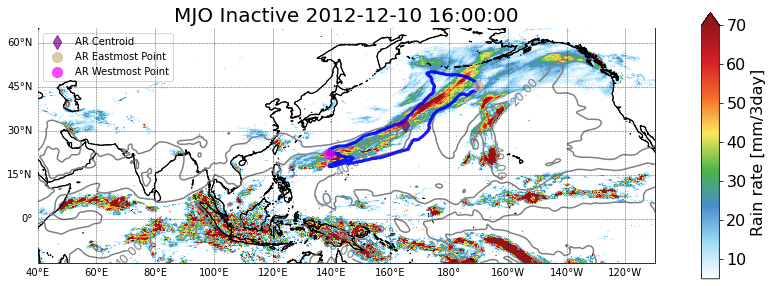

In [27]:
#non Active MJO

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
ax.set_title('MJO Inactive '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(erm_slice1['lon'], erm_slice1['lat'], erm_slice1, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.scatter(cnt_lon, cnt_lat, c='purple', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='tan', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)
# ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('orange',), transform=ccrs.PlateCarree(),zorder=5, vmin=0,linewidths=3) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Rain rate [mm/3day]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
# plt.legend()
plt.clabel(cdssss, inline = True,
           fontsize=12, fmt='%1.2f', colors = 'gray')
plt.legend(loc='upper left')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/src/Paper_draft_stuff/figures/Fig_1_Non_Act.png", dpi=350, bbox_inches='tight')

fig.show()

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
<ipython-input-13-e162b1317e58>:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


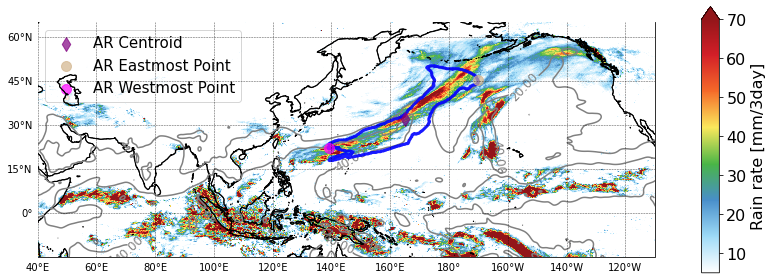

In [13]:
#non Active MJO

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
# ax.set_title('Non-MJO '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(erm_slice1['lon'], erm_slice1['lat'], erm_slice1, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.scatter(cnt_lon, cnt_lat, c='purple', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='tan', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)
# ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('orange',), transform=ccrs.PlateCarree(),zorder=5, vmin=0,linewidths=3) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Rain rate [mm/3day]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
# plt.legend()
plt.clabel(cdssss, inline = True,
           fontsize=12, fmt='%1.2f', colors = 'gray')
plt.legend(loc='upper left',fontsize=15)
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
# fig.savefig("/home/disk/orca/csmall3/AR_testing_research/src/Paper_draft_stuff/figures/Fig_1_Non_Act.png", dpi=350, bbox_inches='tight')
fig.savefig("/home/disk/orca/csmall3/public_html/research/ARs/Overall_analysis/Final_Analysis/2025_07_18_Publication_Figures/Meth_Eg_Rain_Non_MJO.png", dpi=350, bbox_inches='tight')

fig.show()

<ipython-input-29-a4b06b442a70>:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


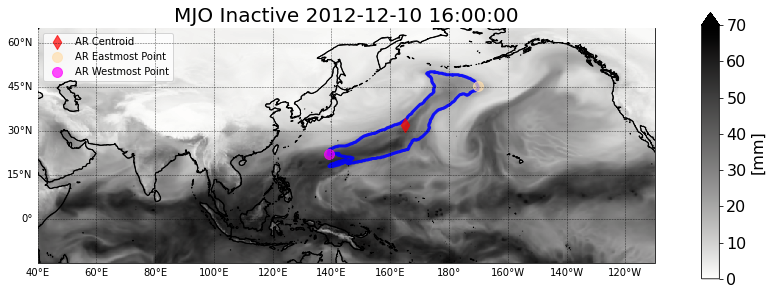

In [29]:
#plot the TPW too

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

colormap=cmaps.cmocean_gray_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
ax.set_title('MJO Inactive '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
# cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(lon_tpw, lat_tpw, plt_tpw, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=0,vmax=70)
# ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
# ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('orange',), transform=ccrs.PlateCarree(),zorder=5, vmin=0,linewidths=3) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='red', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='navajowhite', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('[mm]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left')
# plt.legend()
# plt.clabel(cdssss, inline = True,
#            fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/src/Paper_draft_stuff/figures/Fig_1_Non_Act_TPW.png", dpi=350, bbox_inches='tight')

fig.show()

<ipython-input-15-3160709314f5>:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


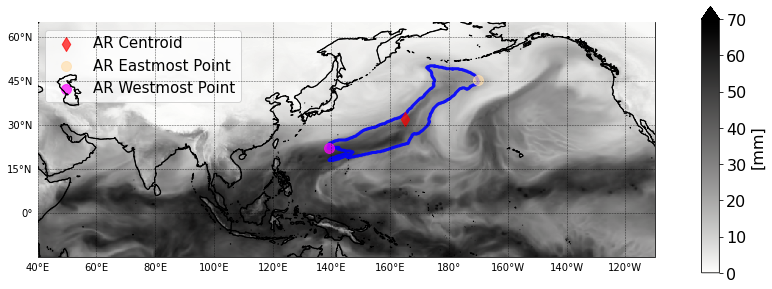

In [15]:
#plot the TPW too

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

colormap=cmaps.cmocean_gray_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
# ax.set_title('MJO Inactive '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
# cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(lon_tpw, lat_tpw, plt_tpw, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=0,vmax=70)
# ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
# ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('orange',), transform=ccrs.PlateCarree(),zorder=5, vmin=0,linewidths=3) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='red', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='navajowhite', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('[mm]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left',fontsize=15)
# plt.legend()
# plt.clabel(cdssss, inline = True,
#            fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/public_html/research/ARs/Overall_analysis/Final_Analysis/2025_07_18_Publication_Figures/Meth_Eg_TPW_Non_MJO.png", dpi=350, bbox_inches='tight')

fig.show()

In [13]:
#first set of variables

tpw_array_non_mjo = plt_tpw
lon_tpw_non_mjo = lon_tpw
lat_tpw_non_mjo = lat_tpw
erm_slice1_non_mjo = erm_slice1
erm_slc1_lon_non_mjo = erm_slice1['lon']
erm_slc1_lat_non_mjo = erm_slice1['lat']
erm_slice2_non_mjo = erm_slice2
erm_slc2_lon_non_mjo = erm_slice2['lon']
erm_slc2_lat_non_mjo = erm_slice2['lat']
cnt_lon_non_mjo = cnt_lon
cnt_lat_non_mjo = cnt_lat
end_lon_non_mjo = end_lons
end_lat_non_mjo = end_lats
start_lon_non_mjo = start_lons
start_lat_non_mjo = start_lats
mask_ary_non_mjo = mask_ary
mask_lon_non_mjo = mask_lon
mask_lat_non_mjo = mask_lat

## MJO Active

In [4]:
#bring in the ARs
#bring in the ARs
non_mjo_df = pd.read_csv('/home/disk/orca/csmall3/AR_testing_research/src/Landfall_tests/Combined_MJO_src/test_text/ERM_3day_WC_OVR_Non_MJO_90_Per.csv')
non_mjo_df = non_mjo_df.drop(columns=['Unnamed: 0'])
non_mjo_df['Datetime'] = pd.to_datetime(non_mjo_df['Date'])

#gotta only keep things that are from July 2000 onwards, just in case
filtered_df = non_mjo_df.loc[(non_mjo_df['Datetime'] >= '2000-07-01')
                     & (non_mjo_df['Datetime'] < '2023-01-01')]



In [17]:
#pull out the specific AR we want here
ar_test = xr.open_dataset(filtered_df['AR ID'].iloc[85])

#pull the specific date we want
date_oi = dt.datetime(2005,11,18,6) #need to filter by this datetime

#the geographic slices for ERA5/IMERG
max_lat =65
min_lat=-20
min_lon=30 #-113.75
max_lon=260


#dates for the filtering for tpw and MJO LPT
moi = str(date_oi.month).rjust(2, '0')
doi = str(date_oi.day).rjust(2, '0')
hoi = str(date_oi.hour).rjust(2, '0')
yoi = str(date_oi.year)
ldom = str(calendar.monthrange(date_oi.year, date_oi.month)[1])

#get the day of year
# new_year = fin_new_time.year
# year_oi += [new_year]
day_of_year = date_oi.timetuple().tm_yday

#bring in tpw data
tpw_test = xr.open_dataset('/home/orca/data/model_anal/era5/from_rda/tcwv/e5.oper.an.sfc.128_137_tcwv.ll025sc.'+yoi+moi+'0100_'+yoi+moi+ldom+'23.nc')

LatIndexer, LonIndexer, TimeIndexer  = 'latitude', 'longitude', 'time'
tpw_slice = tpw_test.sel(**{LatIndexer: slice(max_lat, min_lat),
                LonIndexer: slice(min_lon, max_lon),
                TimeIndexer: slice(date_oi,date_oi)})
tpw_ary = tpw_slice['TCWV']


#bring in mjo data
fin_time = date_oi
year = date_oi.year
nxt_year = year + 1
mjo_test = xr.open_dataset('/home/orca/bkerns/lib/lpt/lpt-python-public/ERA5/data/era5/g20_72h/thresh12/systems/lpt_composite_mask_'+str(year)+'060100_'+str(nxt_year)+'063023_mjo_lpt.nc')
mjo_mask=mjo_test['mask_with_accumulation']
clean_mjo = mjo_mask

TimeIndexer = 'time'
mjo_slice = clean_mjo.sel(**{TimeIndexer: slice(fin_time, fin_time)})

# bring the ERM data as 3-day accumulated precipiation
# erm_test = xr.open_dataset('/home/orca/bkerns/projects/coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.'+str(yoi)+'.nc')
## MODIFIED DIRECTORY
erm_test = xr.open_dataset('/home/orca/bkerns/projects/doe_coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.'+str(yoi)+'.nc')

#need to slice this. Need 2 slices
erm_ary=erm_test['precip'][day_of_year-1]


#ERM geography slice 1
max_lat =65
min_lat=-20
min_lon=30 #-113.75
max_lon=180

# min_lon=30 #-113.75
# max_lon=260

LatIndexer, LonIndexer = 'lat', 'lon'
erm_slice1 = erm_ary.sel(**{LatIndexer: slice(min_lat, max_lat),
                LonIndexer: slice(min_lon, max_lon)})


#ERM geography slice 2
max_lat =65
min_lat=-20
min_lon=-180 #-113.75
max_lon=-100

LatIndexer, LonIndexer = 'lat', 'lon'
erm_slice2 = erm_ary.sel(**{LatIndexer: slice(min_lat, max_lat),
                LonIndexer: slice(min_lon, max_lon)})

#slice the AR array
TimeIndexer  = 'time'
ar_slice = ar_test.sel(**{TimeIndexer: slice(date_oi, date_oi)})

mask_ary = ar_slice['mask_at_end_time'][0]
mask_lon = ar_slice['lon']
mask_lat = ar_slice['lat']

#plot stuff for the TPW and etc
plt_tpw = tpw_ary[0]
lon_tpw = tpw_ary['longitude']
lat_tpw = tpw_ary['latitude']

#plot MJO
plot_mjo = mjo_slice[0]
lon_mjo = mjo_slice['lon']
lat_mjo = mjo_slice['lat']



In [18]:
cnt_lat=ar_slice['centroid_lat'][0].data
cnt_lon=ar_slice['centroid_lon'][0].data

#let's try to find the easternmost point in this thing

mask_ary=mask_ary


lon_2d, lat_2d = np.meshgrid(mask_lon.data,mask_lat.data)
max_lon = []
max_lat = []

lon_in_mask = lon_2d[mask_ary==1]
lat_in_mask = lat_2d[mask_ary==1]

if len(lon_2d[mask_ary==1]) == 0:
    max_lon.append(np.nan)
    max_lat+=[np.nan]

else:
    mx_lon=np.nanmax(lon_2d[mask_ary==1])
    # print(jjj)

    max_lon.append(mx_lon)
    max_lat+=[lat_in_mask[np.argmax(lon_in_mask)]]

#make arrays and drop nans
max_lat = np.array(max_lat)
max_lon = np.array(max_lon)

lon_values = max_lon
lat_values = max_lat


end_lats = lat_values[-1]
end_lons = lon_values[-1]

#let's try to make westernmost point
#let's try to find the easternmost point in this thing

mask_ary=mask_ary


lon_2d, lat_2d = np.meshgrid(mask_lon.data,mask_lat.data)
max_lon = []
max_lat = []

lon_in_mask = lon_2d[mask_ary==1]
lat_in_mask = lat_2d[mask_ary==1]

if len(lon_2d[mask_ary==1]) == 0:
    max_lon.append(np.nan)
    max_lat+=[np.nan]

else:
    mx_lon=np.nanmin(lon_2d[mask_ary==1])
    # print(jjj)

    max_lon.append(mx_lon)
    max_lat+=[lat_in_mask[np.argmin(lon_in_mask)]]

#make arrays and drop nans
max_lat = np.array(max_lat)
max_lon = np.array(max_lon)

lon_values = max_lon
lat_values = max_lat


start_lats = lat_values[0]
start_lons = lon_values[0]



/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
<ipython-input-37-799682ddfce9>:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


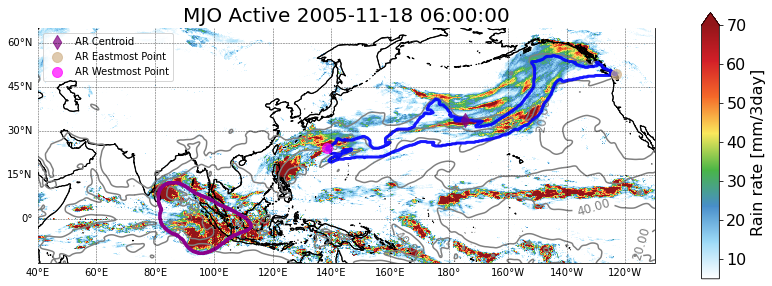

In [37]:
#MJO active/not connected

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html
colormap=cmaps.WhiteBlueGreenYellowRed
from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
ax.set_title('MJO Active '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(erm_slice1['lon'], erm_slice1['lat'], erm_slice1, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='purple', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='tan', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Rain rate [mm/3day]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left')
# plt.legend()
plt.clabel(cdssss, inline = True,
           fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/src/Paper_draft_stuff/figures/Fig_1_Non_MJO.png", dpi=350, bbox_inches='tight')

fig.show()

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
<ipython-input-19-6a7c3b6c3e81>:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


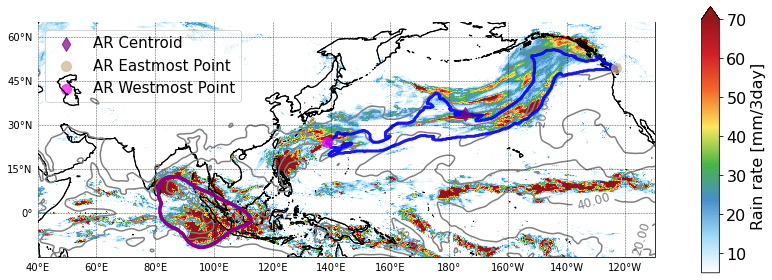

In [19]:
#MJO active/not connected

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html
colormap=cmaps.WhiteBlueGreenYellowRed
from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
# ax.set_title('MJO Active '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(erm_slice1['lon'], erm_slice1['lat'], erm_slice1, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='purple', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='tan', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Rain rate [mm/3day]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left',fontsize=15)
# plt.legend()
plt.clabel(cdssss, inline = True,
           fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/public_html/research/ARs/Overall_analysis/Final_Analysis/2025_07_18_Publication_Figures/Meth_Eg_Rain_Non_Act.png", dpi=350, bbox_inches='tight')

fig.show()

<ipython-input-34-cfedac7cac62>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


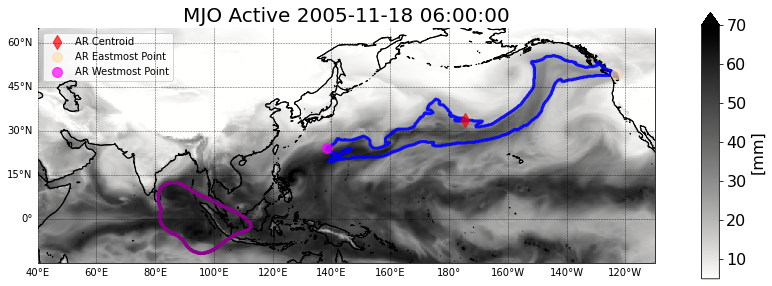

In [34]:
#plot tpw
#MJO active/not connected

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html
colormap=cmaps.cmocean_gray_r
from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
ax.set_title('MJO Active '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
# cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(lon_tpw, lat_tpw, plt_tpw, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
# ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='red', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='navajowhite', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('[mm]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left')
# plt.legend()
# plt.clabel(cdssss, inline = True,
#            fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/src/Paper_draft_stuff/figures/Fig_1_Non_MJO_TPW.png", dpi=350, bbox_inches='tight')

fig.show()

<ipython-input-21-c5c012e76e21>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


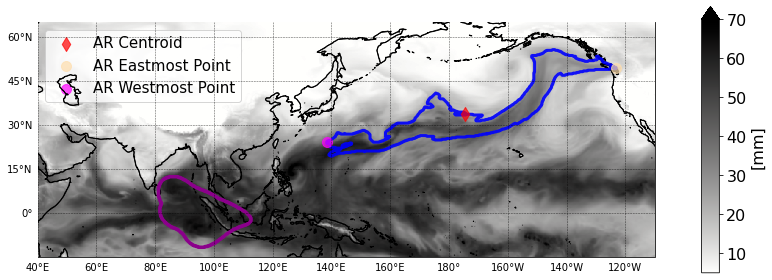

In [21]:
#plot tpw
#MJO active/not connected

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html
colormap=cmaps.cmocean_gray_r
from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
# ax.set_title('MJO Active '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
# cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(lon_tpw, lat_tpw, plt_tpw, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
# ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='red', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='navajowhite', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('[mm]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left',fontsize=15)
# plt.legend()
# plt.clabel(cdssss, inline = True,
#            fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/public_html/research/ARs/Overall_analysis/Final_Analysis/2025_07_18_Publication_Figures/Meth_Eg_TPW_Non_Act.png", dpi=350, bbox_inches='tight')

fig.show()

In [17]:

#second set of variables

tpw_array_mjo_act = plt_tpw
lon_tpw_mjo_act = lon_tpw
lat_tpw_mjo_act = lat_tpw
erm_slice1_mjo_act = erm_slice1
erm_slc1_lon_mjo_act = erm_slice1['lon']
erm_slc1_lat_mjo_act = erm_slice1['lat']
erm_slice2_mjo_act = erm_slice2
erm_slc2_lon_mjo_act = erm_slice2['lon']
erm_slc2_lat_mjo_act = erm_slice2['lat']
cnt_lon_mjo_act = cnt_lon
cnt_lat_mjo_act = cnt_lat
end_lon_mjo_act = end_lons
end_lat_mjo_act = end_lats
start_lon_mjo_act = start_lons
start_lat_mjo_act = start_lats
mask_ary_mjo_act = mask_ary
mask_lon_mjo_act = mask_lon
mask_lat_mjo_act = mask_lat
plot_mjo_mjo_act = plot_mjo
lon_mjo_mjo_act = lon_mjo
lat_mjo_mjo_act = lat_mjo

## MJO Connected

In [6]:
#bring in the ARs
non_mjo_df = pd.read_csv('/home/disk/orca/csmall3/AR_testing_research/Text_data/hourly_ARs/Deg_5_landfall/Non_Start_Cali_90_Per.csv')
non_mjo_df = non_mjo_df.drop(columns=['Unnamed: 0'])
non_mjo_df['Datetime'] = pd.to_datetime(non_mjo_df['Date'])

#gotta only keep things that are from July 2000 onwards, just in case
filtered_df = non_mjo_df.loc[(non_mjo_df['Datetime'] >= '2000-07-01')
                     & (non_mjo_df['Datetime'] < '2023-01-01')]

In [23]:
#pull out the specific AR we want here
ar_test = xr.open_dataset(filtered_df['AR ID'].iloc[5])

#pull the specific date we want
date_oi = dt.datetime(2001,11,23,7) #need to filter by this datetime

#the geographic slices for ERA5/IMERG
max_lat =65
min_lat=-20
min_lon=30 #-113.75
max_lon=260


#dates for the filtering for tpw and MJO LPT
moi = str(date_oi.month).rjust(2, '0')
doi = str(date_oi.day).rjust(2, '0')
hoi = str(date_oi.hour).rjust(2, '0')
yoi = str(date_oi.year)
ldom = str(calendar.monthrange(date_oi.year, date_oi.month)[1])

#get the day of year
# new_year = fin_new_time.year
# year_oi += [new_year]
day_of_year = date_oi.timetuple().tm_yday

#bring in tpw data
tpw_test = xr.open_dataset('/home/orca/data/model_anal/era5/from_rda/tcwv/e5.oper.an.sfc.128_137_tcwv.ll025sc.'+yoi+moi+'0100_'+yoi+moi+ldom+'23.nc')

LatIndexer, LonIndexer, TimeIndexer  = 'latitude', 'longitude', 'time'
tpw_slice = tpw_test.sel(**{LatIndexer: slice(max_lat, min_lat),
                LonIndexer: slice(min_lon, max_lon),
                TimeIndexer: slice(date_oi,date_oi)})
tpw_ary = tpw_slice['TCWV']


#bring in mjo data
fin_time = date_oi
year = date_oi.year
nxt_year = year + 1
mjo_test = xr.open_dataset('/home/orca/bkerns/lib/lpt/lpt-python-public/ERA5/data/era5/g20_72h/thresh12/systems/lpt_composite_mask_'+str(year)+'060100_'+str(nxt_year)+'063023_mjo_lpt.nc')
mjo_mask=mjo_test['mask_with_accumulation']
clean_mjo = mjo_mask

TimeIndexer = 'time'
mjo_slice = clean_mjo.sel(**{TimeIndexer: slice(fin_time, fin_time)})

# bring the ERM data as 3-day accumulated precipiation
# erm_test = xr.open_dataset('/home/orca/bkerns/projects/coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.'+str(yoi)+'.nc')
## MODIFIED DIRECTORY
erm_test = xr.open_dataset('/home/orca/bkerns/projects/doe_coastal/extreme_rain/global_gridded_erm/data/processed/daily_precip_and_erm.3days.imerg.v7.'+str(yoi)+'.nc')

#need to slice this. Need 2 slices
erm_ary=erm_test['precip'][day_of_year-1]


#ERM geography slice 1
max_lat =65
min_lat=-20
min_lon=30 #-113.75
max_lon=180

# min_lon=30 #-113.75
# max_lon=260

LatIndexer, LonIndexer = 'lat', 'lon'
erm_slice1 = erm_ary.sel(**{LatIndexer: slice(min_lat, max_lat),
                LonIndexer: slice(min_lon, max_lon)})


#ERM geography slice 2
max_lat =65
min_lat=-20
min_lon=-180 #-113.75
max_lon=-100

LatIndexer, LonIndexer = 'lat', 'lon'
erm_slice2 = erm_ary.sel(**{LatIndexer: slice(min_lat, max_lat),
                LonIndexer: slice(min_lon, max_lon)})

#slice the AR array
TimeIndexer  = 'time'
ar_slice = ar_test.sel(**{TimeIndexer: slice(date_oi, date_oi)})

mask_ary = ar_slice['mask_at_end_time'][0]
mask_lon = ar_slice['lon']
mask_lat = ar_slice['lat']

#plot stuff for the TPW and etc
plt_tpw = tpw_ary[0]
lon_tpw = tpw_ary['longitude']
lat_tpw = tpw_ary['latitude']

#plot MJO
plot_mjo = mjo_slice[0]
lon_mjo = mjo_slice['lon']
lat_mjo = mjo_slice['lat']



In [24]:
cnt_lat=ar_slice['centroid_lat'][0].data
cnt_lon=ar_slice['centroid_lon'][0].data

#let's try to find the easternmost point in this thing

mask_ary=mask_ary


lon_2d, lat_2d = np.meshgrid(mask_lon.data,mask_lat.data)
max_lon = []
max_lat = []

lon_in_mask = lon_2d[mask_ary==1]
lat_in_mask = lat_2d[mask_ary==1]

if len(lon_2d[mask_ary==1]) == 0:
    max_lon.append(np.nan)
    max_lat+=[np.nan]

else:
    mx_lon=np.nanmax(lon_2d[mask_ary==1])
    # print(jjj)

    max_lon.append(mx_lon)
    max_lat+=[lat_in_mask[np.argmax(lon_in_mask)]]

#make arrays and drop nans
max_lat = np.array(max_lat)
max_lon = np.array(max_lon)

lon_values = max_lon
lat_values = max_lat


end_lats = lat_values[-1]
end_lons = lon_values[-1]

#let's try to make westernmost point
#let's try to find the easternmost point in this thing

mask_ary=mask_ary


lon_2d, lat_2d = np.meshgrid(mask_lon.data,mask_lat.data)
max_lon = []
max_lat = []

lon_in_mask = lon_2d[mask_ary==1]
lat_in_mask = lat_2d[mask_ary==1]

if len(lon_2d[mask_ary==1]) == 0:
    max_lon.append(np.nan)
    max_lat+=[np.nan]

else:
    mx_lon=np.nanmin(lon_2d[mask_ary==1])
    # print(jjj)

    max_lon.append(mx_lon)
    max_lat+=[lat_in_mask[np.argmin(lon_in_mask)]]

#make arrays and drop nans
max_lat = np.array(max_lat)
max_lon = np.array(max_lon)

lon_values = max_lon
lat_values = max_lat


start_lats = lat_values[0]
start_lons = lon_values[0]



/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/disk/orca/csmall3/anaconda3/envs/hyco_env/lib/python3.8/site-packages/cartopy/crs.py:

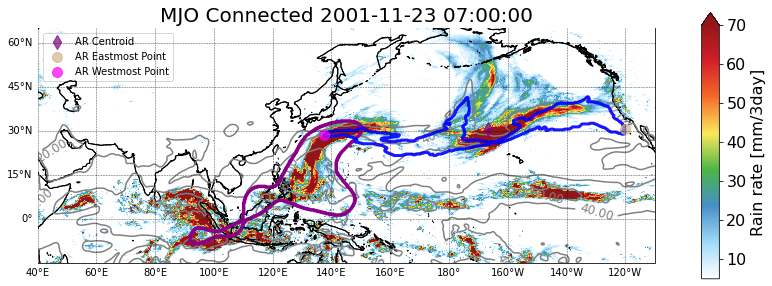

In [39]:
#non Active MJO

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r
colormap=cmaps.WhiteBlueGreenYellowRed

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
ax.set_title('MJO Connected '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(erm_slice1['lon'], erm_slice1['lat'], erm_slice1, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='purple', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='tan', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)



# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Rain rate [mm/3day]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left')
# plt.legend()
plt.clabel(cdssss, inline = True,
           fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/src/Paper_draft_stuff/figures/Fig_1_MJO.png", dpi=350, bbox_inches='tight')

fig.show()

/home/disk/orca/csmall3/anaconda3/envs/new_2025_env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
<ipython-input-25-3d03f02d0606>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


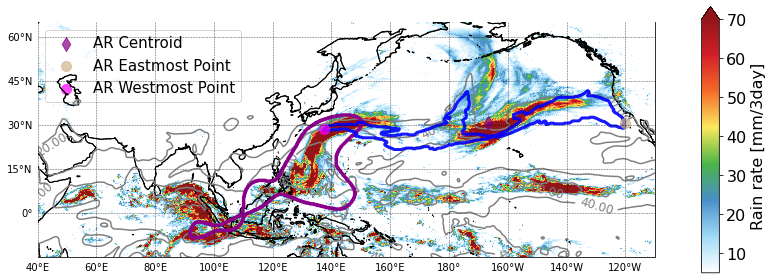

In [25]:
#non Active MJO

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r
colormap=cmaps.WhiteBlueGreenYellowRed

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
# ax.set_title('MJO Connected '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(erm_slice1['lon'], erm_slice1['lat'], erm_slice1, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='purple', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='tan', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)



# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Rain rate [mm/3day]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left',fontsize=15)
# plt.legend()
plt.clabel(cdssss, inline = True,
           fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/public_html/research/ARs/Overall_analysis/Final_Analysis/2025_07_18_Publication_Figures/Meth_Eg_Rain_MJO_Conn.png", dpi=350, bbox_inches='tight')

fig.show()

<ipython-input-40-d131c7701b03>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


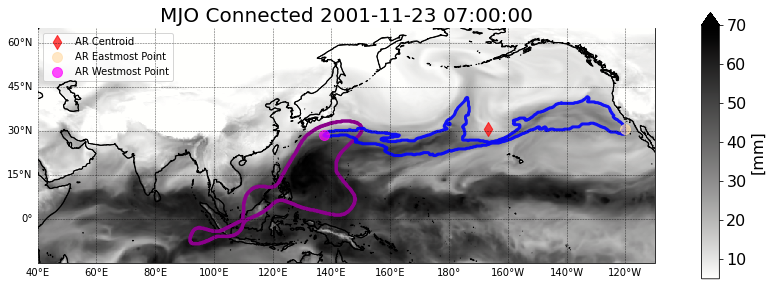

In [40]:
#plot tpw
#non Active MJO

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r
colormap=cmaps.cmocean_gray_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
ax.set_title('MJO Connected '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
# cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(lon_tpw, lat_tpw, plt_tpw, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
# ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='red', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='navajowhite', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('[mm]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left')
# plt.legend()
# plt.clabel(cdssss, inline = True,
#            fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/AR_testing_research/src/Paper_draft_stuff/figures/Fig_1_MJO_TPW.png", dpi=350, bbox_inches='tight')

fig.show()

<ipython-input-26-6169a52240e0>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


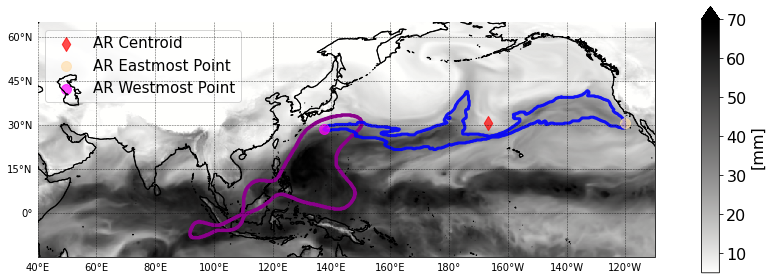

In [26]:
#plot tpw
#non Active MJO

#play around with mjo colors
#https://matplotlib.org/stable/gallery/color/named_colors.html

from scipy.ndimage import gaussian_filter
cm = 180
# colormap = cmaps.matlab_jet
# colormap = cmaps.MPL_RdBu_r
colormap=cmaps.cmocean_gray_r

fig = plt.figure(figsize=[14, 7])
political_boundaries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))
# ax.set_title('MJO Connected '+str(date_oi)+'', fontsize=20)		
# ax.set_title(str(date_oi), fontsize=20)			   
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='none', zorder=7)
ax.coastlines('50m', linewidth=1, zorder=7)
# ax.set_extent([100, 250, 0, 60], crs=ccrs.PlateCarree())#set west coast in a second
minlon = 70 + cm
maxlon = -140 + cm

ax.set_extent([minlon, maxlon, -15, 65], ccrs.PlateCarree())
# cdssss=ax.contour(lon_tpw, lat_tpw, gaussian_filter(plt_tpw.values, 2, mode='reflect'), levels=np.arange(0,int(plt_tpw.max().values), 20), colors='gray', linewidths=1.5, transform=ccrs.PlateCarree(),zorder=10,linestyle='--')
css=ax.pcolormesh(lon_tpw, lat_tpw, plt_tpw, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
# ax.pcolormesh(erm_slice2['lon'], erm_slice2['lat'], erm_slice2, cmap = colormap, transform=ccrs.PlateCarree(),zorder=5, vmin=5,vmax=70)
ax.contour(lon_mjo, lat_mjo, plot_mjo, [0.5], colors=('darkmagenta',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3.5) #no mjo to plot!
ax.contour(mask_lon, mask_lat, mask_ary, [0.5], colors=('blue',), transform=ccrs.PlateCarree(),zorder=15, vmin=0,linewidths=3, alpha = 0.9)
ax.scatter(cnt_lon, cnt_lat, c='red', marker='d', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Centroid', alpha=0.7)
ax.scatter(end_lons, end_lats, c='navajowhite', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Eastmost Point', alpha=0.7)
ax.scatter(start_lons, start_lats, c='magenta', marker='o', s=100,linewidths=1, zorder=20, transform=ccrs.PlateCarree(), label='AR Westmost Point', alpha=0.7)


# cbar = plt.colorbar(css, ax=ax,orientation='horizontal',extend='min',aspect=30, shrink=0.7, pad=0.06)
cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=15, shrink=0.7, pad=0.06, extend='max')
# cbar = plt.colorbar(css, ax=ax,orientation='vertical',aspect=30, pad=0.06, extend='max')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('[mm]', fontsize =16)

#try adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0.5, color='k', alpha=0.7, linestyle='--', zorder=20)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 15))
plt.legend(loc='upper left',fontsize=15)
# plt.legend()
# plt.clabel(cdssss, inline = True,
#            fontsize=12, fmt='%1.2f', colors = 'gray')
# ax.text(0.95, 0.05, "TPW: every 20 mm starting at 0 mm.", ha='right', color='k', fontweight='bold', transform=ax.transAxes, zorder=20)
# plt.figtext(0.28, .07, 'Composite of 6-hourly 200 hPA winds from December 1, 1999 through April 30, 2022', wrap=True)
fig.savefig("/home/disk/orca/csmall3/public_html/research/ARs/Overall_analysis/Final_Analysis/2025_07_18_Publication_Figures/Meth_Eg_TPW_MJO_Conn.png", dpi=350, bbox_inches='tight')

fig.show()

In [21]:
#third set of variables

tpw_array_mjo_conn = plt_tpw
lon_tpw_mjo_conn = lon_tpw
lat_tpw_mjo_conn = lat_tpw
erm_slice1_mjo_conn = erm_slice1
erm_slc1_lon_mjo_conn = erm_slice1['lon']
erm_slc1_lat_mjo_conn = erm_slice1['lat']
erm_slice2_mjo_conn = erm_slice2
erm_slc2_lon_mjo_conn = erm_slice2['lon']
erm_slc2_lat_mjo_conn = erm_slice2['lat']
cnt_lon_mjo_conn = cnt_lon
cnt_lat_mjo_conn = cnt_lat
end_lon_mjo_conn = end_lons
end_lat_mjo_conn = end_lats
start_lon_mjo_conn = start_lons
start_lat_mjo_conn = start_lats
mask_ary_mjo_conn = mask_ary
mask_lon_mjo_conn = mask_lon
mask_lat_mjo_conn = mask_lat
plot_mjo_mjo_conn = plot_mjo
lon_mjo_mjo_conn = lon_mjo
lat_mjo_mjo_conn = lat_mjo